In [0]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True)

Files already downloaded and verified


In [0]:
from tqdm import tqdm_notebook
from PIL import Image
import numpy as np
n = 0
s = np.zeros(3)
sq = np.zeros(3)
for data, l in tqdm_notebook(train):
  x = np.array(data)/255
  s += x.sum(axis=(0,1))
  sq += np.sum(np.square(x), axis=(0,1))
  n += x.shape[0]*x.shape[1]

mu = s/n
std = np.sqrt((sq/n - np.square(mu)))
print(mu, sq/n, std, n)


[0.49139968 0.48215841 0.44653091] [0.30249857 0.29176174 0.26781806] [0.24703223 0.24348513 0.26158784] 51200000


In [0]:
import numpy as np
import datatransforms

from torchvision import transforms
channel_means = (0.49139968, 0.48215841, 0.44653091)
channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
trans =  datatransforms.Transforms(normalize=True, mean=channel_means, stdev=channel_stdevs)
fillmeans = (np.array(channel_means)*255).astype(np.uint8)
# Train Phase transformations
train_transforms = trans.train_transforms([
                                       #  transforms.Resize((28, 28)),
                                       #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-15.0, 15.0), fill=tuple(fillmeans)),
                                       transforms.RandomHorizontalFlip(),
                                       ], 
                                       
                                       [transforms.RandomErasing(value = tuple(channel_means))])

# Test Phase transformations
test_transforms = trans.test_transforms()

In [0]:
tuple(fillmeans)

(125, 122, 113)

In [0]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
import dataloaders

dataloader = dataloaders.DataLoader()

# train dataloader
train_loader = dataloader.load(train)

# test dataloader
test_loader = dataloader.load(test)

torch.Size([128, 3, 32, 32])
torch.Size([128])


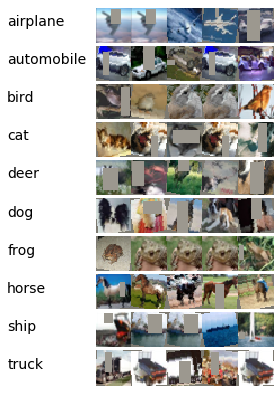

In [0]:
from __future__ import print_function
channel_means = (0.49139968, 0.48215841, 0.44653091)
channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
def unnormalize(img):
  img = img.numpy().astype(dtype=np.float32)
  
  for i in range(img.shape[0]):
    img[i] = (img[i]*channel_stdevs[i])+channel_means[i]
  
  return np.transpose(img, (1,2,0))
  #return np.transpose(img, (1, 2, 0))

%matplotlib inline
import matplotlib.pyplot as plt
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

num_classes = 10
# display 10 images from each category. 
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
r, c = 10, 11
n = 5
fig = plt.figure(figsize=(7,7))
fig.subplots_adjust(hspace=0.01, wspace=0.01)
for i in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==i)[0], n)
    ax = plt.subplot(r, c, i*c+1)
    ax.text(-1.5, 0.5, class_names[i], fontsize=14)
    plt.axis('off')
    for j in range(1, n+1):
      plt.subplot(r, c, i*c+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

In [0]:
import resnetmodel
import torch

model = resnetmodel.ResNet18()
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)
model.summary((3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [0]:

import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
EPOCHS = 20
L2lambda = 0
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True, weight_decay=L2lambda)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=EPOCHS)
L1lambda = 0
model.gotrain(optimizer, train_loader, test_loader, EPOCHS, "/content/drive/My Drive", scheduler, True, L1lambda)

Validation loss decreased (100000.000000 --> 1.038701).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0109, Accuracy: 49.13%; Test set: Average loss: 1.0387, Accuracy: 63.32%
Learning Rate = 0.010436


Validation loss decreased (1.038701 --> 0.980289).  Saving model ...
Epoch: 2, Train set: Average loss: 0.0079, Accuracy: 64.27%; Test set: Average loss: 0.9803, Accuracy: 65.29%
Learning Rate = 0.028019


Epoch: 3, Train set: Average loss: 0.0068, Accuracy: 69.39%; Test set: Average loss: 1.2427, Accuracy: 64.00%
Learning Rate = 0.052032


Validation loss decreased (0.980289 --> 0.804879).  Saving model ...
Epoch: 4, Train set: Average loss: 0.0061, Accuracy: 73.06%; Test set: Average loss: 0.8049, Accuracy: 73.82%
Learning Rate = 0.076037


Validation loss decreased (0.804879 --> 0.685155).  Saving model ...
Epoch: 5, Train set: Average loss: 0.0053, Accuracy: 76.28%; Test set: Average loss: 0.6852, Accuracy: 77.09%
Learning Rate = 0.093596


Epoch: 6, Train set: Average loss: 0.0047, Accuracy: 78.76%; Test set: Average loss: 0.7024, Accuracy: 77.71%
Learning Rate = 0.100000


Validation loss decreased (0.685155 --> 0.518698).  Saving model ...
Epoch: 7, Train set: Average loss: 0.0043, Accuracy: 80.52%; Test set: Average loss: 0.5187, Accuracy: 82.65%
Learning Rate = 0.098740


Epoch: 8, Train set: Average loss: 0.0039, Accuracy: 82.53%; Test set: Average loss: 0.5676, Accuracy: 80.63%
Learning Rate = 0.095036


Validation loss decreased (0.518698 --> 0.406024).  Saving model ...
Epoch: 9, Train set: Average loss: 0.0036, Accuracy: 83.80%; Test set: Average loss: 0.4060, Accuracy: 86.11%
Learning Rate = 0.089074


Epoch: 10, Train set: Average loss: 0.0033, Accuracy: 85.11%; Test set: Average loss: 0.4192, Accuracy: 86.51%
Learning Rate = 0.081152


Validation loss decreased (0.406024 --> 0.360376).  Saving model ...
Epoch: 11, Train set: Average loss: 0.0031, Accuracy: 85.93%; Test set: Average loss: 0.3604, Accuracy: 87.86%
Learning Rate = 0.071668


Epoch: 12, Train set: Average loss: 0.0028, Accuracy: 87.32%; Test set: Average loss: 0.3859, Accuracy: 87.19%
Learning Rate = 0.061098


Validation loss decreased (0.360376 --> 0.330859).  Saving model ...
Epoch: 13, Train set: Average loss: 0.0026, Accuracy: 88.35%; Test set: Average loss: 0.3309, Accuracy: 88.73%
Learning Rate = 0.049972


Epoch: 14, Train set: Average loss: 0.0024, Accuracy: 89.27%; Test set: Average loss: 0.3566, Accuracy: 89.02%
Learning Rate = 0.038846


Validation loss decreased (0.330859 --> 0.316687).  Saving model ...
Epoch: 15, Train set: Average loss: 0.0022, Accuracy: 90.34%; Test set: Average loss: 0.3167, Accuracy: 89.87%
Learning Rate = 0.028280


Validation loss decreased (0.316687 --> 0.309929).  Saving model ...
Epoch: 16, Train set: Average loss: 0.0019, Accuracy: 91.38%; Test set: Average loss: 0.3099, Accuracy: 90.42%
Learning Rate = 0.018803


Validation loss decreased (0.309929 --> 0.289966).  Saving model ...
Epoch: 17, Train set: Average loss: 0.0017, Accuracy: 92.39%; Test set: Average loss: 0.2900, Accuracy: 91.08%
Learning Rate = 0.010891


Validation loss decreased (0.289966 --> 0.280493).  Saving model ...
Epoch: 18, Train set: Average loss: 0.0015, Accuracy: 93.42%; Test set: Average loss: 0.2805, Accuracy: 91.46%
Learning Rate = 0.004939


Validation loss decreased (0.280493 --> 0.275819).  Saving model ...
Epoch: 19, Train set: Average loss: 0.0013, Accuracy: 94.29%; Test set: Average loss: 0.2758, Accuracy: 91.60%
Learning Rate = 0.001248


Validation loss decreased (0.275819 --> 0.271988).  Saving model ...
Epoch: 20, Train set: Average loss: 0.0012, Accuracy: 94.57%; Test set: Average loss: 0.2720, Accuracy: 91.66%
Learning Rate = 0.000000



Submitted by G Uday Kiran and Srilakshmi V